In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [81]:
path='/content/drive/MyDrive/signature images'

In [82]:
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
import matplotlib.pyplot as plt
from plot_model import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [83]:
def define_D(in_shape=(128,128,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [84]:
def define_G(latent_dim):
    model = Sequential()
	  # foundation for 16x16 image
    n_nodes = 256 * 16 * 16
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))
    return model

In [85]:
def define_GAN(model_G, model_D):
	
	model_D.trainable = False
	model = Sequential()
	model.add(model_G)
	model.add(model_D)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [86]:
def load_real_images():
    datagen = ImageDataGenerator(rescale=1./255)
    X = datagen.flow_from_directory(path,
                                    target_size= (128,128),
                                    batch_size=300,class_mode='binary')
    data_list = []
    batch_index = 0
    while batch_index <= X.batch_index:
        data = X.next()
        data_list.append(data[0])
        batch_index += 1
    img_array = np.asarray(data_list)
    return img_array

In [87]:
def generate_real_images(dataset, n_samples):
    i = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[i]
    y = np.ones((n_samples,1))
    return X, y

In [88]:
def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples)
    X = X.reshape(n_samples, latent_dim)
    return X

In [89]:
def generate_fake_images(model_G, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    X = model_G.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [90]:
def summarize_performance(epoch, model_G, model_D, dataset, latent_dim, n_samples=100):
  model_G.save('/content/model'+str(epoch)+'.h5')
  X_real, y_real = generate_real_images(dataset, n_samples)
  _, acc_real = model_D.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_images(model_G, latent_dim, n_samples)
  _, acc_fake = model_D.evaluate(x_fake, y_fake, verbose=0)
  print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [91]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch/2)
    
    for i in range(n_iter):
        X_real, y_real = generate_real_images(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_images(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print('%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [104]:
def train_GAN(model_G, model_D, model_GAN, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_images(dataset, half_batch)
			X_fake, y_fake = generate_fake_images(model_G, latent_dim, half_batch)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = model_D.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = model_GAN.train_on_batch(X_gan, y_gan)
			print('%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance
		if (i+1) % 10 == 0:
			summarize_performance(i, model_G, model_D, dataset, latent_dim)

In [105]:
latent_dim =100
model_D = define_D()
model_G = define_G(latent_dim)
model_GAN = define_GAN(model_G, model_D)
dataset=load_real_images()
train_GAN(model_G, model_D,model_GAN,dataset[0], latent_dim)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 300 images belonging to 2 classes.
1, 1/1, d=0.721, g=0.693
2, 1/1, d=0.666, g=0.693
3, 1/1, d=0.612, g=0.692
4, 1/1, d=0.567, g=0.690
5, 1/1, d=0.517, g=0.684
6, 1/1, d=0.470, g=0.666
7, 1/1, d=0.441, g=0.626
8, 1/1, d=0.462, g=0.549
9, 1/1, d=0.546, g=0.462
10, 1/1, d=0.694, g=0.410
Accuracy real: 100%, fake: 0%
11, 1/1, d=1.050, g=0.422
12, 1/1, d=0.755, g=0.498
13, 1/1, d=0.711, g=0.588
14, 1/1, d=0.685, g=0.678
15, 1/1, d=0.684, g=0.732
16, 1/1, d=0.681, g=0.741
17, 1/1, d=0.678, g=0.731
18, 1/1, d=0.676, g=0.714
19, 1/1, d=0.677, g=0.710
20, 1/1, d=0.676, g=0.724
Accuracy real: 75%, fake: 100%
21, 1/1, d=0.670, g=0.741
22, 1/1, d=0.668, g=0.730
23, 1/1, d=0.669, g=0.712
24, 1/1, d=0.672, g=0.720
25, 1/1, d=0.670, g=0.721
26, 1/1, d=0.667, g=0.710
27, 1/1, d=0.667, g=0.709
28, 1/1, d=0.667, g=0.691
29, 1/1, d=0.660, g=0.706
30, 1/1, d=0.659, g=0.723
Accuracy real: 100%, fake: 71%
31, 1/1, d=0.671, g=0.736
32, 1/1, d=0.661, g=0.758
33, 1/1, d=0.664, g=0.729
34, 1/1, d=0.663, 

KeyboardInterrupt: ignored

In [2]:
model = load_model('/content/model39.h5')

NameError: ignored

In [101]:
def generate_latent_points(latent_dim, n_samples):
	
	x_input = np.random.randn(latent_dim * n_samples)
	
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

In [102]:
def plot_images(images, n):
	
	images = (images-images.min())/(images.max() - images.min())
	for i in range(n):
		
		plt.subplot(1, n, 1 + i)
		
		plt.axis('off')
		
		plt.imshow(images[i, :, :])
	plt.show()

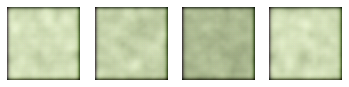

In [103]:
pts = generate_latent_points(100, 30)

X = model.predict(pts)
plot_images(X, 4)